# Выбор локации для скважины

В компании «ГлавРосГосНефть» поставлена задача определить оптимальное место для бурения новой скважины. Для этого собраны данные о пробах нефти из трех различных регионов, в каждом из которых имеется 10 000 месторождений с измерениями качества нефти и объема её запасов. 

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Импорт библиотек**

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
PROFIT_ONE_BARREL = 450
PROFIT_ONE_PRODUCT = PROFIT_ONE_BARREL * 1000

WELL_BUDGET = 10000000000
WELL_AMOUNT = 200

THRESHOLD = 0.025

## Загрузка и подготовка данных

In [4]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
display(geo_0.head())
print(geo_0.shape)
print()
geo_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


(100000, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(geo_1.head())
print(geo_1.shape)
print()
geo_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


(100000, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
display(geo_2.head())
print(geo_2.shape)
print()
geo_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(100000, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


*Вывод по загрузке данных:*

1. данные загружены и соответствуют ТЗ
2. названия столбцов соответвуют ТЗ
3. типы данных правильные

In [8]:
for df in [geo_0, geo_1, geo_2]:
    print(f'Количество пропущенных значений: {df.isna().sum()}')
    print()
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')
    print()

Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0

Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0

Количество пропущенных значений: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество явных дубликатов: 0



*Вывод*:

1. В датафреймах нет пропущенных значений
2. В датафреймах нет явных и неявных дубликатов

In [9]:
len(geo_0['id'].unique())

99990

In [10]:
len(geo_1['id'].unique())

99996

In [11]:
len(geo_2['id'].unique())

99996

Есть повторяющиеся id, это нужно устранить

In [12]:
geo_0 = geo_0.drop_duplicates(subset='id', keep='first')
geo_1 = geo_1.drop_duplicates(subset='id', keep='first')
geo_2 = geo_2.drop_duplicates(subset='id', keep='first')

len(geo_0['id'].unique()), geo_0.shape, len(geo_1['id'].unique()), geo_1.shape, len(geo_2['id'].unique()), geo_2.shape

(99990, (99990, 5), 99996, (99996, 5), 99996, (99996, 5))

In [13]:
geo_0.set_index('id', inplace=True)
geo_1.set_index('id', inplace=True)
geo_2.set_index('id', inplace=True)


Вывод: 

1. Данные загружены и соответствуют ТЗ
2. Названия столбцов соответвуют ТЗ
3. Типы данных правильные
4. В датафреймах нет пропущенных значений
5. В датафреймах нет явных и неявных дубликатов
7. Удалены повторяющиеся значения id

### Исследовательский анализ данных

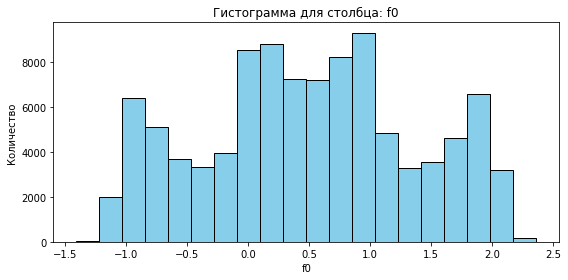

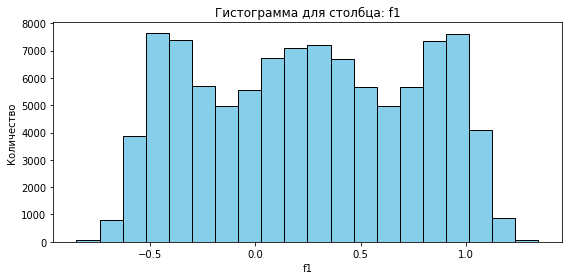

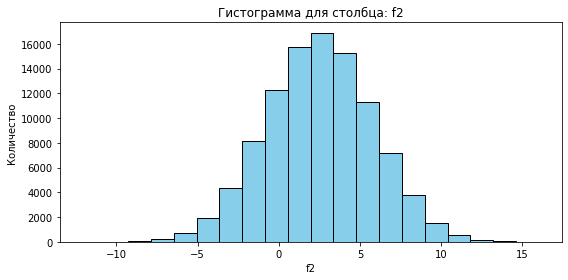

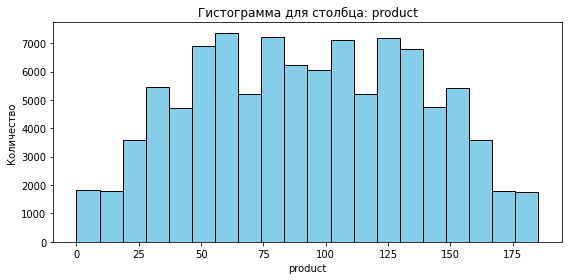

In [14]:
numeric_columns = geo_0.select_dtypes(include=['float64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    geo_0[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

Распределение у признака f2 - сильно похоже на нормальное, у остальных - ненормальное

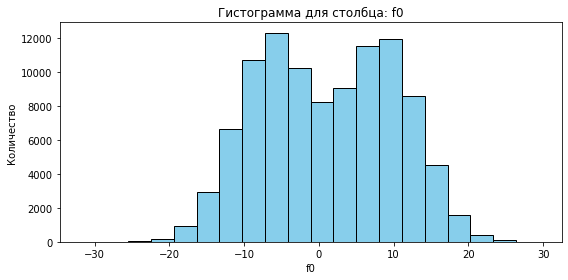

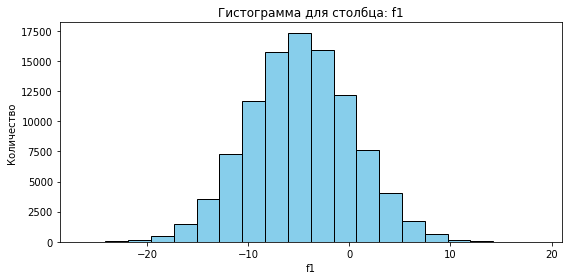

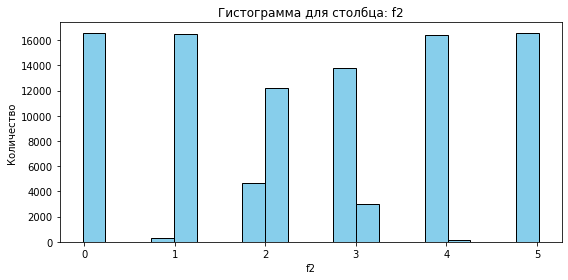

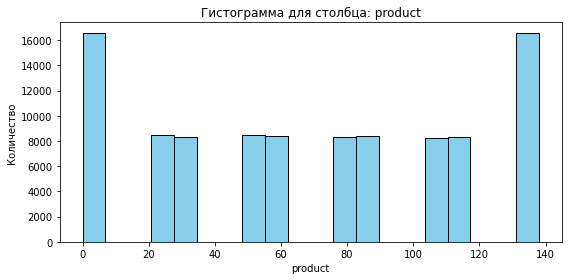

In [15]:
numeric_columns = geo_1.select_dtypes(include=['float64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    geo_1[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

Распределение у признака f1 - сильно похоже на нормальное, у остальных - ненормальное

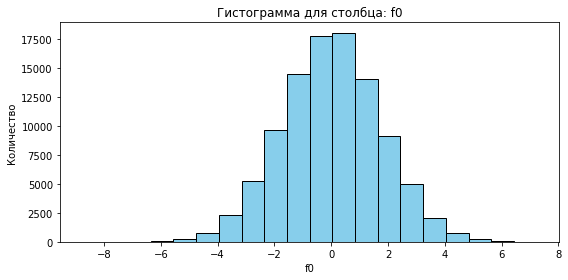

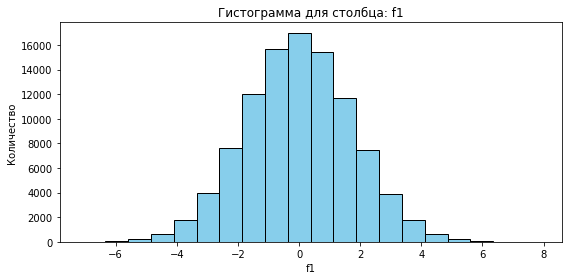

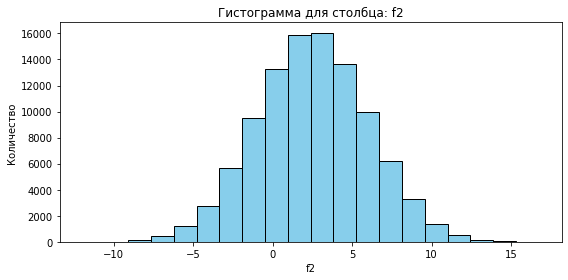

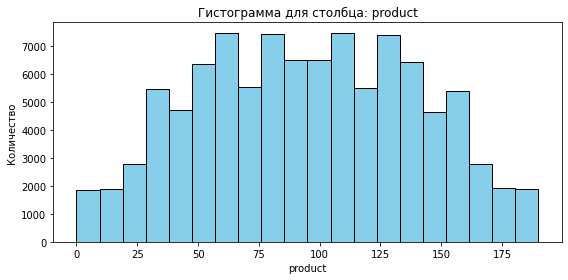

In [16]:
numeric_columns = geo_2.select_dtypes(include=['float64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    geo_2[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

У признаков f1, f2, f3 распределение очень похоже на нормальное

*Вывод:*

У большинства признаков в датафреймах распределение не нормальное

### Корреляционных анализ

Так как мы будем работать с линейной регрессией, нам важно провести корреляционный анализ.
Из предыдущего пункта мы выяснили, что не у всех признаков нормальное распределение, поэтому будет использовать коэф. корреляции по спирмену

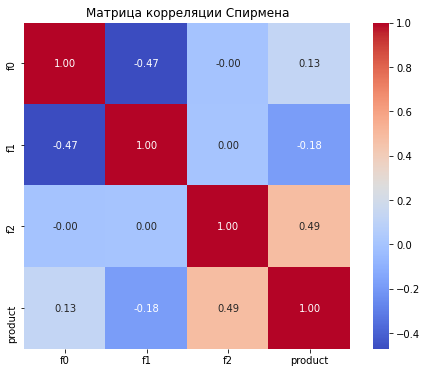

In [17]:
correlation_matrix = geo_0.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляции Спирмена')
plt.show()

Мультиколлинеарности нет

Самая сильная корреляционная положительная связь у признаков product и f2

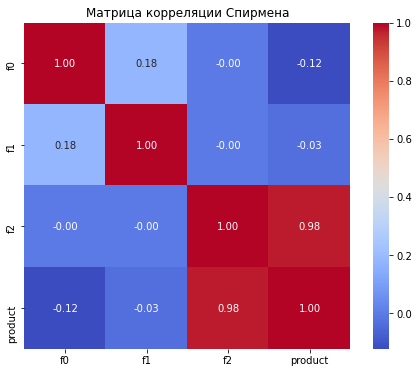

In [18]:
correlation_matrix = geo_1.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляции Спирмена')
plt.show()

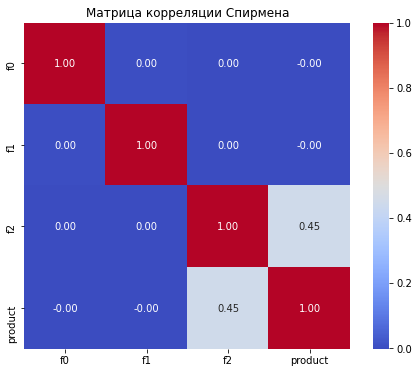

In [19]:
correlation_matrix = geo_2.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляции Спирмена')
plt.show()

Мультиколлинеарности нет

Самая сильная корреляционная положительная связь у признаков product и f2

## Обучение и проверка модели

Функция:

1. Разбиение данных на обучающую и валидационную выборку
2. Маштабирование данных
3. Обучение модели
4. Предсказание 

In [20]:
def model(df):

    X = df.drop('product', axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)

    X_val_scaled = scaler.transform(X_val)

    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    predict_val = model.predict(X_val_scaled)
    val_df = X_val.merge(y_val, left_index=True, right_index=True)
    val_df['product_predicted'] = predict_val

    val_score = np.sqrt(mean_squared_error(y_val, predict_val))
    
    average_predicted = predict_val.mean()

    print(f'RMSE на валидационной выборке: {val_score}')
    print(f'Средний запас предсказанного сырья: {average_predicted}')

    return model, val_df

In [21]:
model_geo_0, geo_0_pred = model(geo_0)

RMSE на валидационной выборке: 37.68508926201444
Средний запас предсказанного сырья: 92.60984027552017


In [22]:
model_geo_1, geo_1_pred = model(geo_1)

RMSE на валидационной выборке: 0.8928265978121422
Средний запас предсказанного сырья: 68.57703454115173


In [23]:
model_geo_2, geo_2_pred = model(geo_2)

RMSE на валидационной выборке: 40.080822438088305
Средний запас предсказанного сырья: 94.93478722287514


Лучшее показание метрики RMSE у модели для geo_1 

(Так же остается вопрос, не из-за мультиколлнеарности ли это?)

*Вывод:*

1. Обучены модели линейной регресси
2. Рассчитаны значения метрики RMSE: 37.685, 0.893, 40.081
3. Рассчитаны средние запасы предсказанного сырья: 92.610, 68.577, 94.935

## Подготовка к расчёту прибыли

In [24]:
#достаточный объём сырья для безубыточной разработки новой скважины
volume = WELL_BUDGET / PROFIT_ONE_PRODUCT

#то есть для одной скважины нужно производить сырье в объеме:
one_volume = volume / WELL_AMOUNT

print(f'Объем безубыточного производства: {round(one_volume) + 1}')

Объем безубыточного производства: 112


Сравненине полученного объёма сырья со средним запасом в каждом регионе

In [25]:
count = -1
for geo in [geo_0, geo_1, geo_2]:
    count += 1
    diff = geo['product'].mean() - 112
    print(f' для региона geo_{count} разница между средним запасом и целевым объемом {diff}')

 для региона geo_0 разница между средним запасом и целевым объемом -19.500315782256465
 для региона geo_1 разница между средним запасом и целевым объемом -43.17608408195936
 для региона geo_2 разница между средним запасом и целевым объемом -17.001657880666215


*Вывод:* Во всех регионах средний запас меньше, чем целевой объем сырья

## Расчёт прибыли и рисков 

In [26]:
def profit_calculate(df, wells_amount, profit_one_product, well_budget):
 
    top_200_pred = df.sort_values('product_predicted', ascending=False).iloc[:wells_amount]
    
    top_200_product = top_200_pred['product'].sum()
    
    return top_200_product * profit_one_product - well_budget

In [27]:
count = -1
for geo in [geo_0_pred, geo_1_pred, geo_2_pred]:
    count += 1
    
    profit = profit_calculate(geo, 200, PROFIT_ONE_PRODUCT, WELL_BUDGET)
    
    print(f'Прогнозируемая прибыль с лучших 200 скважин в регионе geo_{count}: {profit}')

Прогнозируемая прибыль с лучших 200 скважин в регионе geo_0: 3468529787.422388
Прогнозируемая прибыль с лучших 200 скважин в регионе geo_1: 2415086696.681511
Прогнозируемая прибыль с лучших 200 скважин в регионе geo_2: 2396613000.939848


Применение техники Bootstrap

In [28]:
state = np.random.RandomState(RANDOM_STATE)


def estimated_profit(df, geo_num):
    bootstrap_values = []
    for i in range(1000):
        subsample = df.sample(500, replace=True, random_state=state)
        bootstrap_values.append(
            profit_calculate(subsample, 200, PROFIT_ONE_PRODUCT, WELL_BUDGET)
        )
    bootstrap_values = pd.Series(bootstrap_values)

    average_profit = round(bootstrap_values.mean())
    quant_high = round(np.quantile(bootstrap_values, 0.975))
    quant_low = round(np.quantile(bootstrap_values, 0.025))
    
    # вычисление риска
    risk = (bootstrap_values < 0).mean()  
    risk_percentage = round(risk * 100, 2)

    print(f'для geo_{geo_num}')
    print(f'Средняя ожидаемая прибыль в регионе:      {average_profit}')
    print(f'Минимальная ожидаемая прибыль в регионе:  {quant_low}')
    print(f'Максимальная ожидаемая прибыль в регионе: {quant_high}\n')
    print(f'Риск убытков (вероятность отрицательной прибыли): {risk_percentage}%\n')

In [29]:
geo_num = -1
for geo in [geo_0_pred, geo_1_pred, geo_2_pred]:
    geo_num += 1
    estimated_profit(geo, geo_num)

для geo_0
Средняя ожидаемая прибыль в регионе:      403572064
Минимальная ожидаемая прибыль в регионе:  -137690003
Максимальная ожидаемая прибыль в регионе: 902848311

Риск убытков (вероятность отрицательной прибыли): 5.9%

для geo_1
Средняя ожидаемая прибыль в регионе:      439363670
Минимальная ожидаемая прибыль в регионе:  31747700
Максимальная ожидаемая прибыль в регионе: 845875096

Риск убытков (вероятность отрицательной прибыли): 1.6%

для geo_2
Средняя ожидаемая прибыль в регионе:      367701927
Минимальная ожидаемая прибыль в регионе:  -169188559
Максимальная ожидаемая прибыль в регионе: 877126557

Риск убытков (вероятность отрицательной прибыли): 8.0%



*Вывод:* Исходя из полученных результатов, оптимальным регионом будет geo_1, т.к. минимальная ожидаемая прибыль в регионе: 31747700, что является самым большим значением из всех регионов, также у данного региона минимальный риск 1,6%.

## Общий вывод

**Вывод:**

1. Загрузка и подготовка данных: Данные загружены и соответствуют ТЗ; Названия столбцов соответвуют ТЗ; Типы данных правильные; В датафреймах нет пропущенных значений; В датафреймах нет явных и неявных дубликатов; Удалены повторяющиеся значения id
2. Обучение моделей для каждого региона: Обучены модели линейной регресси; Рассчитаны значения метрики RMSE: 37.685, 0.893, 40.081; Рассчитаны средние запасы предсказанного сырья: 92.610, 68.577, 94.935
3. Объем безубыточного производства: 112
4. Прогнозируемая прибыль с лучших 200 скважин в регионе geo_0: 3468529787.422388; Прогнозируемая прибыль с лучших 200 скважин в регионе geo_1: 2415086696.681511; Прогнозируемая прибыль с лучших 200 скважин в регионе geo_2: 2396613000.939848
5. для geo_0: Средняя ожидаемая прибыль в регионе: 403572064; Минимальная ожидаемая прибыль в регионе:  -137690003; Максимальная ожидаемая прибыль в регионе: 902848311; Риск убытков (вероятность отрицательной прибыли): 5.9%
6. для geo_1: Средняя ожидаемая прибыль в регионе: 439363670; Минимальная ожидаемая прибыль в регионе:  31747700; Максимальная ожидаемая прибыль в регионе: 845875096; Риск убытков (вероятность отрицательной прибыли): 1.6%
7. для geo_2: Средняя ожидаемая прибыль в регионе: 367701927; Минимальная ожидаемая прибыль в регионе:  -169188559; Максимальная ожидаемая прибыль в регионе: 877126557; Риск убытков (вероятность отрицательной прибыли): 8.0%
8. Исходя из полученных результатов, оптимальным регионом будет geo_1, т.к. минимальная ожидаемая прибыль в регионе: 31747700, что является самым большим значением из всех регионов, также у данного региона минимальный риск 1,6%.